In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.close("all")

PATH="C:/Users/..."
os.chdir(PATH)
print("Current working directory -->", PATH)

In [2]:
# Importing working Time Series downloaded via Yahoo finance for the whole year of 2020
SPY=pd.read_csv("SPY.csv", infer_datetime_format=True) # Constitutent 1
TLT=pd.read_csv("TLT.csv", infer_datetime_format=True) # Constitutent 2
GLD=pd.read_csv("GLD.csv", infer_datetime_format=True) # Constitutent 3
SP500=pd.read_csv("SP500.csv", infer_datetime_format=True) # Benchmark

factors_dict = {
    'SPY': SPY,
    'TLT': TLT,
    'GLD': GLD,
    'SP500': SP500,
}

factors_dict['SPY'].head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,318.914307,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,316.499451,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,317.706909,55653900


In [3]:
# Renaming the 'Adj Close'
for k in factors_dict.keys():
    factors_dict[k] = factors_dict[k].rename(columns={"Adj Close": k})
    
factors_dict['SPY'].head(3)

,Date,Open,High,Low,Close,SPY,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,318.914307,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,316.499451,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,317.706909,55653900


In [4]:
# Joining all factors/constituents in one table
master_factors = factors_dict['SPY'][["Date"]]
for k in factors_dict.keys():
    master_factors = pd.merge(
        master_factors,
        factors_dict[k][["Date", k]],
        how='left',
        on=["Date"]
    )
    
master_factors.head(3)

,Date,SPY,TLT,GLD,SP500
0,2020-01-02,318.914307,135.004837,143.949997,3257.850098
1,2020-01-03,316.499451,137.083969,145.860001,3234.850098
2,2020-01-06,317.706909,136.305542,147.389999,3246.280029


In [5]:
# Set 'Date' column to index
master_factors['Date'] = pd.to_datetime(master_factors['Date'], infer_datetime_format=True)
master_factors = master_factors.set_index('Date')

master_factors.head(3)

,SPY,TLT,GLD,SP500
Date,,,,
2020-01-02,318.914307,135.004837,143.949997,3257.850098
2020-01-03,316.499451,137.083969,145.860001,3234.850098
2020-01-06,317.706909,136.305542,147.389999,3246.280029


In [6]:
# Compute the returns then we continue with the dataframe containing only the log returns
for k in master_factors.keys():
    master_factors['log_' + k] = np.log(master_factors[k]) - np.log(master_factors[k].shift(1))

master_returns = master_factors[[c for c in master_factors.columns if c.startswith("log_")]]\
                                .dropna()
master_returns.head(3)

,log_SPY,log_TLT,log_GLD,log_SP500
Date,,,,
2020-01-03,-0.007601,0.015283,0.013181,-0.007085
2020-01-06,0.003808,-0.005695,0.010435,0.003527
2020-01-07,-0.002816,-0.004928,0.003927,-0.002807


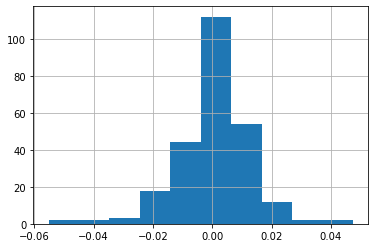

In [8]:
# CHECK
# Seems left/negatively skewed - as expected
master_returns['log_GLD'].hist()

In [9]:
# Computing the portfolio returns with weights SPY:0.5, GLD:0.4, TLT:0.1
portfolio_w = {
    'log_SPY': 0.5,
    'log_GLD': 0.4,
    'log_TLT': 0.1
}

master_returns["rp"]=0
for k, v in portfolio_w.items():
    master_returns["rp"] += v * master_returns[k]
    
master_returns.head(3)

,log_SPY,log_TLT,log_GLD,log_SP500,rp
Date,,,,,
2020-01-03,-0.007601,0.015283,0.013181,-0.007085,0.003000
2020-01-06,0.003808,-0.005695,0.010435,0.003527,0.005508
2020-01-07,-0.002816,-0.004928,0.003927,-0.002807,-0.000330


In [10]:
# CAPM formula: rp - RF =  ALPHA + Beta*(rb – RF)

# rp: portfolio returns vector
# RF: risk free rate - for simplicity we will assume in this exercise that RF (risk free rate) is equal to zero
# ALPHA: the intercept of the OLS
# rb: benchmark returns, here the S&P 500 returns

X_train = master_returns[["rp"]] # portfolio returns
X_train["alpha"] = 1 # Our model needs an intercept so we add a column of 1s
y_train = master_returns[["log_SP500"]] # Benchmark returns

# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_SP500   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     993.2
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           7.07e-89
Time:                        17:09:20   Log-Likelihood:                 804.86
No. Observations:                 251   AIC:                            -1606.
Df Residuals:                     249   BIC:                            -1599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rp             1.6293      0.052     31.516      0.0

<ipython-input-10-ede697f0f797>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["alpha"] = 1 # Our model needs an intercept so we add a column of 1s


-------- Total returns for year 2020 --------
Portfolio:  19.32 %
Benchmark:  14.56 %


<Figure size 864x1152 with 0 Axes>

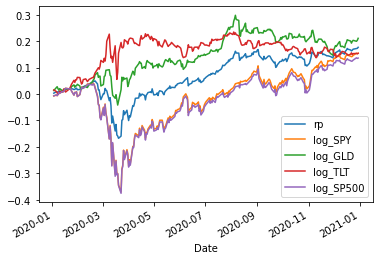

In [11]:
# Cumulative sum
df_cumsum = master_returns[["rp", "log_SPY", "log_GLD", "log_TLT", "log_SP500"]].cumsum()

# ATTENTION !!!
# log(1 + ri) = log(Pi) - log(Pj)
p_annual_ret = np.exp(df_cumsum.at[df_cumsum.index[-1],'rp']) - 1
bm_annual_ret = np.exp(df_cumsum.at[df_cumsum.index[-1],'log_SP500']) - 1
                                   
plt.figure(figsize=(12, 16))
df_cumsum.plot()

print('-------- Total returns for year 2020 --------')
print('Portfolio: ', round(p_annual_ret * 100, 2), "%")
print('Benchmark: ', round(bm_annual_ret * 100, 2), "%")

<Figure size 864x1152 with 0 Axes>

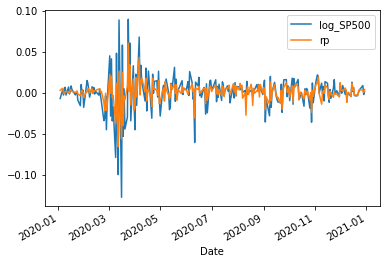

In [12]:
# Time series returns
df_rets = master_returns[["log_SP500", "rp"]]

plt.figure(figsize=(12, 16))
df_rets.plot()

<ipython-input-13-901f32e5b344>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rets["gaussian"] = np.random.normal(mu, sigma, len(master_returns))


(-3.0, 3.0)

<Figure size 576x864 with 0 Axes>

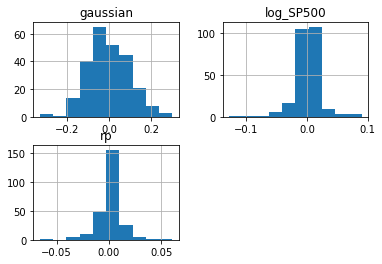

In [13]:
# Histograms returns
df_rets = master_returns[["log_SP500", "rp"]]

mu, sigma = 0, 0.1 # mean and standard deviation
df_rets["gaussian"] = np.random.normal(mu, sigma, len(master_returns))
plt.figure(figsize=(8, 12))
df_rets.hist()
plt.xlim([-3.0, 3.0])

In [14]:
###################################################
#### Technical information ########################

# Tracking Error (TE)
# Volatility
# Correlation
# Beta

In [15]:
# TE
master_returns['TE_1'] = (master_returns['rp'] - master_returns['log_SP500'])**2
TE =  master_returns['TE_1'].sum()
TE = TE/(len(master_returns) - 1)
TE = TE**0.5

In [16]:
# Correlation
p_corr = master_returns['rp'].corr(master_returns['log_SP500'])

In [17]:
# Volatility
weights = np.array(list(portfolio_w.values()))
factor_cov = master_returns[['log_SPY', 'log_TLT', 'log_GLD']].cov()

p_vol = np.sqrt(np.dot(weights.T, np.dot(factor_cov * len(master_returns), weights)))

In [18]:
print('---- Technical Information ----')
print('Volatility: ', round(p_vol, 4)*100, "%")
print('TE: ', round(TE, 4) * 100)
print('Correlation: ', round(p_corr, 2))
print('Beta: ', round(res.params[0], 2))

---- Technical Information ----
Volatility:  15.52 %
TE:  1.24
Correlation:  0.89
Beta:  1.63
